### Step 1: Import Required Libraries
This code block imports the necessary libraries and modules required for data preprocessing, feature engineering, and machine learning tasks. The libraries include:

- `pandas` and `numpy` for data manipulation and numerical computations.
- `sklearn` modules for preprocessing, pipeline creation, model building, and evaluation.
- `re` for regular expression operations.

These libraries will be used throughout the notebook for various tasks such as data cleaning, feature extraction, and building machine learning pipelines.

In [65]:
# Step 1: Import Required Libraries
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score
import pandas as pd
import numpy as np
import re
import shap

### Step 2: Define Helper Functions
This step defines a set of helper functions that will be used for data preprocessing and feature engineering:

1. **`convert_to_binary(column, pattern)`**: Extracts binary encodings from a column based on a given regular expression pattern.
2. **`aspect_to_cardinal(aspect)`**: Converts an aspect value (in degrees) into its corresponding cardinal direction (e.g., N, NE, E, etc.).
3. **`process_avalanche_data(df)`**: Processes avalanche data by:
    - Extracting binary values for elevation and aspect.
    - Pivoting the data to create separate columns for each problem type.
    - Resetting the index to make latitude and longitude regular columns.


In [66]:
# Step 2: Define Helper Functions
def convert_to_binary(column, pattern):
    """Function to extract the binary encodings in the column."""
    return column.str.extract(pattern).fillna(0).agg(''.join, axis=1).astype(int)

# Convert lat and lon to polar coordinates
def convert_to_polar(df):
    df['radius'] = np.sqrt(df['lat']**2 + df['lon']**2)  # Calculate radius
    df['theta'] = np.arctan2(df['lat'], df['lon'])       # Calculate angle in radians
    return df

def aspect_to_cardinal(aspect):
    """
    Convert aspect in degrees to cardinal direction.
    """
    if (aspect >= 337.5 or aspect < 22.5):
        return "N"
    elif (aspect >= 22.5 and aspect < 67.5):
        return "NE"
    elif (aspect >= 67.5 and aspect < 112.5):
        return "E"
    elif (aspect >= 112.5 and aspect < 157.5):
        return "SE"
    elif (aspect >= 157.5 and aspect < 202.5):
        return "S"
    elif (aspect >= 202.5 and aspect < 247.5):
        return "SW"
    elif (aspect >= 247.5 and aspect < 292.5):
        return "W"
    elif (aspect >= 292.5 and aspect < 337.5):
        return "NW"
    else:
        return "Unknown"

def process_avalanche_data(df):
    """Pivot the problems into columns and extract binary values."""
    # Extract binary values for elevation and aspect
    df['problem_elevation_binary'] = convert_to_binary(
        df['problem_elevation'], r'(\d)-(\d)-(\d)')
    df['problem_aspect_binary'] = convert_to_binary(
        df['problem_aspect'], r'(\d)-(\d)-(\d)-(\d)-(\d)-(\d)-(\d)-(\d)')
    
    index_columns = df.columns.difference(['problem', 'problem_elevation_binary', 'problem_aspect_binary', 'size_min', 'size_max', 'likelihood_min', 'likelihood_max'])

    pivoted = df.pivot_table(
        index=['elevation', 'start_angle', 'confidence', 'aspect', 'alp_rating', 'tln_rating', 'btl_rating', 'wind_dir', 'wind_speed_max', 'snowfall_sum','temperature_max','theta','radius', 'month'],
        columns='problem',
        values=['problem_elevation_binary',
                'problem_aspect_binary', 'size_min',
               'size_max', 'likelihood_min', 'likelihood_max'],
        aggfunc='first'
    )

    
    pivoted.columns = [f"{col[1]}_{col[0]}" for col in pivoted.columns]

    # Reset the index to make lat and lon regular columns
    pivoted = pivoted.reset_index()

    return pivoted

def cardinal_to_sin_cos(direction):
    """
    Convert cardinal direction to its corresponding degree and calculate the sine value.

    """
    # Mapping of cardinal directions to degrees
    direction_to_degree = {
        'N': 0,
        'NE': 45,
        'E': 90,
        'SE': 135,
        'S': 180,
        'SW': 225,
        'W': 270,
        'NW': 315
    }
    
    # Get the degree value for the direction
    degree = direction_to_degree.get(direction.upper(), None)
    
    if degree is None:
        raise ValueError(f"Invalid cardinal direction: {direction}")
    
    # Convert degrees to radians
    radians = np.radians(degree)
    

    # Calculate the sine value
    return np.sin(radians), np.cos(radians)


In [67]:
# Step 3: Load and Parse Data
df = pd.read_json("calculated_merge_data.json", lines=True)

### Step 5: Parse Features for Easier Encoding
This step involves parsing and transforming specific features in the dataset to make them easier to encode:

1. **`size`**: Extracts the minimum and maximum size values into separate columns (`size_min` and `size_max`) and coverts to an int.
2. **`likelihood`**: Removes unnecessary suffixes and splits the likelihood range into two separate columns (`likelihood_min` and `likelihood_max`).
3. Handles missing values in `likelihood_max` by filling them with the corresponding values from `likelihood_min`.

In [68]:
# Step 5: Parse Features for Easier Encoding
df[['size_min', 'size_max']] = df['size'].str.extract(
    r'size-(\d+)-(\d+)', expand=True).astype(int)
df['likelihood'] = df['likelihood'].str.replace('_en', '')
df[['likelihood_min', 'likelihood_max']] = df['likelihood'].str.extract(
    r'likelihood-([a-zA-Z]+)(?:_([a-zA-Z]+))?'
)

df['likelihood_min'] = df['likelihood_min']
df['likelihood_max'] = df['likelihood_max'].fillna(df['likelihood_min'])




### Process Avalanche Data
This step processes the avalanche data by pivoting problem-related columns into separate features and extracting binary encodings for elevation and aspect. 

The latitude and longitude columns are converted to radius and theta.

The aspect values (in degrees) are converted into their corresponding cardinal directions (e.g., N, NE, E, etc.) for better interpretability.

Calculated slope angles below 15 degrees are removed as these are seen as either erronous enters from a user or erreous calculations by google earth/improper pin placement. Extremely rare and thus not worth detecting as anomalous since anything below 20 should be consider anomalous 

Binary columns are converted to integers from float and missing values are replaced with 0.

In [69]:
#convert lat and lon to polar coordinates
df = convert_to_polar(df)

df['month'] = pd.to_datetime(df['date']).dt.month

df = df.drop(['date', 'forecast_region'], axis=1)

# Step 6: Process Avalanche Data
avalanche_wrangled = process_avalanche_data(df)

# Step 7: Convert Aspect to Cardinal Directions
avalanche_wrangled['aspect'] = avalanche_wrangled['aspect'].apply(
    lambda x: aspect_to_cardinal(x) if isinstance(x, (int, float)) else x)

avalanche_wrangled[['aspect_sin', 'aspect_cos']] = avalanche_wrangled['aspect'].apply(
    lambda x: cardinal_to_sin_cos(x) if isinstance(x, str) else (np.nan, np.nan)
).apply(pd.Series)



# Convert wind direction to sine value
avalanche_wrangled['wind_dir_sin'] = np.sin(np.radians(df['wind_dir']))
avalanche_wrangled['wind_dir_cos'] = np.cos(np.radians(df['wind_dir']))


avalanche_wrangled = avalanche_wrangled[avalanche_wrangled['start_angle'] >= 15]
avalanche_wrangled = avalanche_wrangled[avalanche_wrangled['elevation'] > 0]

avalanche_wrangled = avalanche_wrangled.drop(['wind_dir', 'aspect'], axis = 1)


# Step 8: Handle Missing Values and Convert Floats to Integers
# Exclude 'theta' and 'radius' from the float64 columns
float_columns = avalanche_wrangled.select_dtypes(include=['float64']).columns
columns_to_convert = [col for col in float_columns if col not in ['theta', 'radius', 'wind_dir', 'wind_speed_max', 'snowfall_sum', 'temperature_max']]

# Fill NaN values with 0 and convert the remaining columns to integers
avalanche_wrangled[columns_to_convert] = avalanche_wrangled[columns_to_convert].fillna(0).astype(int)


likelihood_mapping = {
    'unlikely': 1,
    'possible': 2,
    'likely': 3,
    'verylikely': 4,
    'certain': 5
}

# Identify all likelihood columns
likelihood_columns = [col for col in avalanche_wrangled.columns if 'likelihood' in col]

# Apply the mapping to the likelihood columns
avalanche_wrangled[likelihood_columns] = avalanche_wrangled[likelihood_columns].replace(likelihood_mapping)

avalanche_wrangled  = avalanche_wrangled[['elevation', 'start_angle', 'aspect_sin','aspect_cos', 'wind_dir_cos','wind_dir_sin', 'wind_speed_max',
                          'snowfall_sum', 'temperature_max', 'theta', 'radius', 'month']]



C:\Users\Admin\AppData\Local\Temp\ipykernel_23476\2597614696.py:53: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avalanche_wrangled[likelihood_columns] = avalanche_wrangled[likelihood_columns].replace(likelihood_mapping)


### Define Column Groups
In this step, the columns in the dataset are grouped into three categories for preprocessing:

1. **Ordinal Columns**: Columsn like ratings or confidence with obvious order.
2. **Categorical Columns**: These are the trickier columns like forecast problems which I am using a binary encoding
3. **Numerical Columns**: Columns with continuous numerical values start angle etc. Things like aspect, lat, lon are being encoded using sin encoding to make distance trends more recognizable 

These groups will be used to apply specific preprocessing steps tailored to each type of data.

In [ ]:
ordinal_order = {
    'alp_rating': ['low', 'moderate', 'considerable', 'high', 'extreme'],
    'tln_rating': ['low', 'moderate', 'considerable', 'high', 'extreme'],
    'btl_rating': ['norating', 'low', 'moderate', 'considerable', 'high', 'extreme'],
    'confidence': ['notdefined', 'low', 'moderate', 'high']

}


# # Step 9: Define Column Groups
ordinal_columns = avalanche_wrangled[ordinal_order.keys()].columns
categorical_columns = avalanche_wrangled.select_dtypes(
    include=['object', 'category']).columns.drop(ordinal_order.keys())
numerical_columns = avalanche_wrangled.select_dtypes(
    exclude=['object', 'category']).columns


### Define Preprocessors
This step defines preprocessors for different types of columns in the dataset:

1. **Numeric Preprocessor**: Handles missing values in numerical columns by replacing them with a constant value (e.g., 0).
2. **Ordinal Preprocessor**: Handles missing values in ordinal columns by replacing them with "unknown" and applies ordinal encoding based on predefined categories.
3. **Categorical Preprocessor**: Handles missing values in categorical columns by replacing them with "unknown" and applies one-hot encoding to convert categories into binary features.

These preprocessors are combined into a `ColumnTransformer` to apply the appropriate transformations to each column group.

In [71]:
#Define Preprocessors
numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_constant", SimpleImputer(strategy="constant", fill_value=0))
    ]
)

ordinal_preprocessor = Pipeline(
    steps=[
        ("imputation_constant", SimpleImputer(
            strategy="constant", fill_value="unknown")),
        ("ordinal", OrdinalEncoder(categories=[
         ordinal_order[col] for col in ordinal_columns]))
    ]
)

categorical_preprocessor = Pipeline(
    steps=[
        ("imputation_constant", SimpleImputer(
            strategy="constant", fill_value="unknown")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_columns),
        # ("ord", ordinal_preprocessor, ordinal_columns),
        # ("cat", categorical_preprocessor, categorical_columns)
    ]
)


In [72]:
# Define Pipeline
# pipeline = Pipeline(steps=[
#     # ("preprocessor", preprocessor),
#     ("isolation_forest", IsolationForest(
#         n_estimators=100, random_state=42))
# ])

pipeline = IsolationForest(n_estimators=100, random_state=42)


In [73]:
X_train, X_test = train_test_split(
    avalanche_wrangled, test_size=0.2, random_state=42)

X_train = preprocessor.fit_transform(X_train)


# onehot_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_columns)
all_columns = numerical_columns.tolist() 

# + ordinal_columns.tolist()

# + onehot_columns.tolist()

# Convert the transformed array back to a DataFrame
transformed_df = pd.DataFrame(X_train, columns=all_columns)

aggegated_df = transformed_df.copy()

pipeline.fit(transformed_df)   



IsolationForest(random_state=42)

In [74]:

aggegated_df['anomaly'] = pipeline.predict(transformed_df)


aggegated_df['anomaly_score'] = pipeline.decision_function(transformed_df)


normal = aggegated_df[aggegated_df['anomaly'] == 1]

anomalies = aggegated_df[aggegated_df['anomaly'] == -1]





In [75]:
normal_sample = np.random.choice(normal.index,size=100,replace=False)
sample = np.append(anomalies.index,normal_sample)


In [76]:


explainer = shap.TreeExplainer(pipeline)
shap_values = explainer(transformed_df)

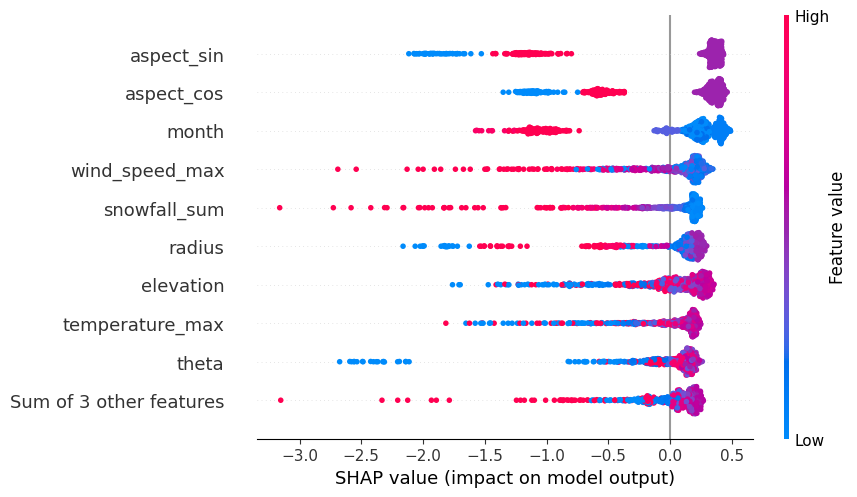

In [77]:
shap.plots.beeswarm(shap_values)

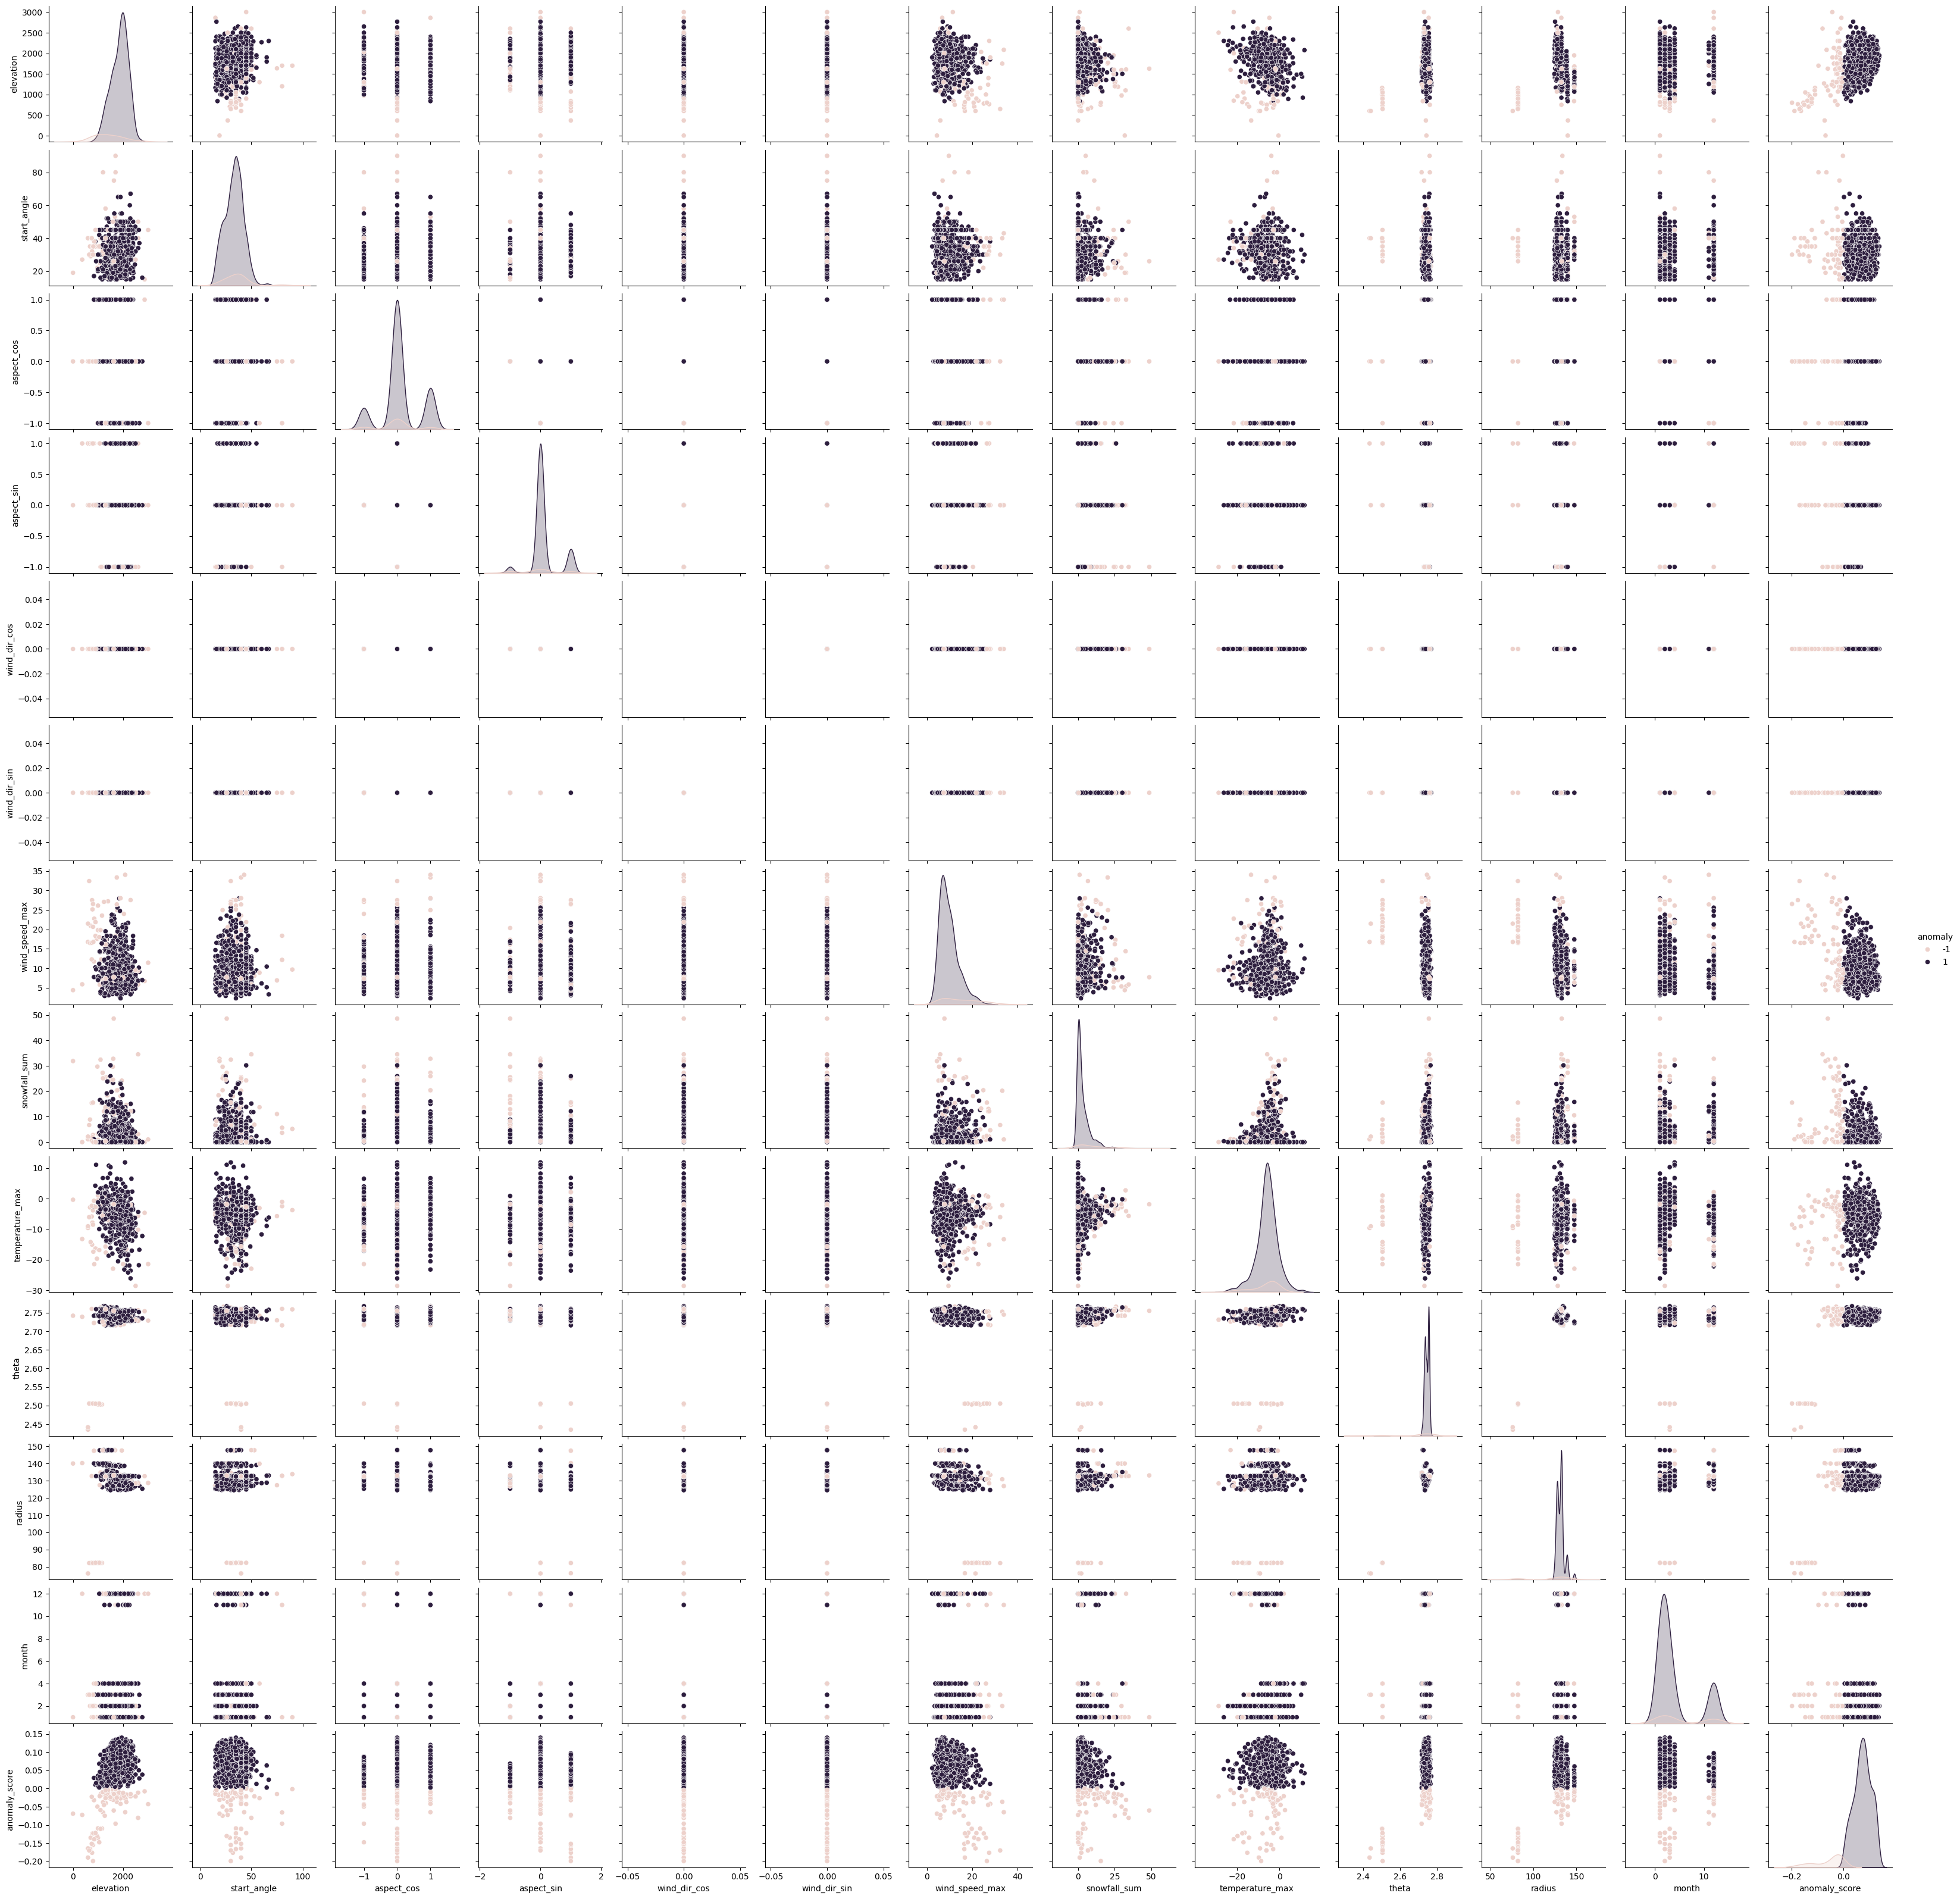

In [79]:
nomal_indices = aggegated_df[aggegated_df['anomaly'] == 1].index

# # Loop through the anomaly indices and generate bar plots
# for i in range(100,110):
#     shap.plots.bar(
#         shap_values[i]
#     )


import seaborn as sns
import matplotlib.pyplot as plt

exlude_columns = ['elevation', 'start_angle', 'aspect', 'wind_dir', 'wind_speed_max',
                          'snowfall_sum', 'temperature_max', 'theta', 'radius', 'month', 'anomaly', 'anomaly_score']

plot_data = aggegated_df[['elevation', 'start_angle', 'aspect_cos', 'aspect_sin','wind_dir_cos', 'wind_dir_sin', 'wind_speed_max',
                          'snowfall_sum', 'temperature_max', 'theta', 'radius', 'month', 'anomaly', 'anomaly_score']]

# remaining_columns = aggegated_df[['alp_rating', 'anomaly_score', 'btl_rating', 'confidence',
#        'deep-persistent-slab_likelihood_max',
#        'deep-persistent-slab_likelihood_min',
#        'deep-persistent-slab_problem_aspect_binary',
#        'deep-persistent-slab_problem_elevation_binary',
#        'deep-persistent-slab_size_max', 'deep-persistent-slab_size_min']]


# Generate pairwise scatter plots for all numerical variables
sns.pairplot(plot_data, kind="scatter", hue="anomaly", diag_kind="kde")

# Show the plot
plt.show()